In [1]:
import jax
import jax.numpy as jnp
import chex
import mctx
from rich import print
import matplotlib.pyplot as plt
import functools

In [2]:
Board = chex.Array
Action = chex.Array
Player = chex.Array
Reward = chex.Array
Done = chex.Array

In [3]:
@chex.dataclass
class Env:
    board: Board
    player: Player
    done: Done
    reward: Reward

In [4]:
BOARD_STRING = """
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 1   2   3   4   5   6   7
"""

def print_board(board: Board):
    board_str = BOARD_STRING
    for i in reversed(range(board.shape[0])):
        for j in range(board.shape[1]):
            board_str = board_str.replace('?', '[green]X[/green]' if board[i, j] == 1 else '[red]O[/red]' if board[i, j] == -1 else ' ', 1)
    print(board_str)

In [5]:
def env_reset(_):
    return Env(
        board=jnp.zeros((6, 7), dtype=jnp.int8),
        player=jnp.int8(1),
        done=jnp.bool_(False),
        reward=jnp.int8(0),
    )

In [6]:
def horizontals(board: Board) -> chex.Array:
    return jnp.stack([
        board[i, j:j+4]
        for i in range(board.shape[0])
        for j in range(board.shape[1] - 3)
    ])

def verticals(board: Board) -> chex.Array:
    return jnp.stack([
        board[i:i+4, j]
        for i in range(board.shape[0] - 3)
        for j in range(board.shape[1])
    ])

def diagonals(board: Board) -> chex.Array:
    return jnp.stack([
        jnp.diag(board[i:i+4, j:j+4])
        for i in range(board.shape[0] - 3)
        for j in range(board.shape[1] - 3)
    ])

def antidiagonals(board: Board) -> chex.Array:
    return jnp.stack([
        jnp.diag(board[i:i+4, j:j+4][::-1])
        for i in range(board.shape[0] - 3)
        for j in range(board.shape[1] - 3)
    ])

def get_winner(board: Board) -> Player:
    all_lines = jnp.concatenate((
        horizontals(board),
        verticals(board),
        diagonals(board),
        antidiagonals(board),
    ))
    x_won = jnp.any(jnp.all(all_lines == 1, axis=1)).astype(jnp.int8)
    o_won = jnp.any(jnp.all(all_lines == -1, axis=1)).astype(jnp.int8)
    return x_won - o_won

In [7]:
def env_step(env: Env, action: Action) -> tuple[Env, Reward, Done]:
    col = action
    row = jnp.argmax(env.board[:, col] == 0)
    invalid_move = env.board[row, col] != 0
    board = env.board.at[row, col].set(jnp.where(env.done | invalid_move, env.board[row, col], env.player))
    reward = jnp.where(env.done, 0, jnp.where(invalid_move, -1, get_winner(board) * env.player)).astype(jnp.int8)
    done = env.done | reward != 0 | invalid_move | jnp.all(board[-1] != 0)
    env = Env(
        board=board,
        player=jnp.where(done, env.player, -env.player),
        done=done,
        reward=reward,
    )
    return env, reward, done

In [8]:
def valid_action_mask(env: Env) -> chex.Array:
    return jnp.where(env.done, jnp.array([False] * env.board.shape[1]), env.board[-1] == 0)

In [9]:
def winning_action_mask(env: Env, player: Player) -> chex.Array:
    env = Env(board=env.board, player=player, done=env.done, reward=env.reward)
    env, reward, done = jax.vmap(env_step, (None, 0))(env, jnp.arange(7, dtype=jnp.int8))
    return reward == 1

In [10]:
def policy_function(env: Env) -> chex.Array:
    return sum((
        valid_action_mask(env).astype(jnp.float32) * 100,
        winning_action_mask(env, -env.player).astype(jnp.float32) * 200,
        winning_action_mask(env, env.player).astype(jnp.float32) * 300,
    ))

In [11]:
def rollout(env: Env, rng_key: chex.PRNGKey) -> Reward:
    def cond(a):
        env, key = a
        return ~env.done
    def step(a):
        env, key = a
        key, subkey = jax.random.split(key)
        action = jax.random.categorical(subkey, policy_function(env))
        env, reward, done = env_step(env, action)
        return env, key
    leaf, key = jax.lax.while_loop(cond, step, (env, rng_key))
    return leaf.reward * leaf.player * env.player

In [12]:
def value_function(env: Env, rng_key: chex.PRNGKey) -> chex.Array:
    return rollout(env, rng_key).astype(jnp.float32)

In [13]:
def root_fn(env: Env, rng_key: chex.PRNGKey) -> mctx.RootFnOutput:
    return mctx.RootFnOutput(
        prior_logits=policy_function(env),
        value=value_function(env, rng_key),
        embedding=env,
    )

In [14]:
def recurrent_fn(params, rng_key, action, embedding):
    env = embedding
    env, reward, done = env_step(env, action)
    recurrent_fn_output = mctx.RecurrentFnOutput(
        reward=reward,
        discount=jnp.where(done, 0, -1).astype(jnp.float32),
        prior_logits=policy_function(env),
        value=jnp.where(done, 0, value_function(env, rng_key)).astype(jnp.float32),
    )
    return recurrent_fn_output, env

In [15]:
@functools.partial(jax.jit, static_argnums=(2,))
def run_mcts(rng_key: chex.PRNGKey, env: Env, num_simulations: int) -> chex.Array:
    batch_size = 1
    key1, key2 = jax.random.split(rng_key)
    policy_output = mctx.muzero_policy(
        params=None,
        rng_key=key1,
        root=jax.vmap(root_fn, (None, 0))(env, jax.random.split(key2, batch_size)),
        recurrent_fn=jax.vmap(recurrent_fn, (None, None, 0, 0)),
        num_simulations=num_simulations,
        max_depth=42,
        qtransform=functools.partial(mctx.qtransform_by_min_max, min_value=-1, max_value=1),
        dirichlet_fraction=0.0,
    )
    return policy_output

In [16]:
env = env_reset(0)
env, reward, done = env_step(env, 3)
env, reward, done = env_step(env, 3)
policy_output = run_mcts(jax.random.PRNGKey(0), env, 1000)
policy_output.action_weights

Array([[0.016, 0.097, 0.189, 0.436, 0.177, 0.048, 0.037]], dtype=float32)

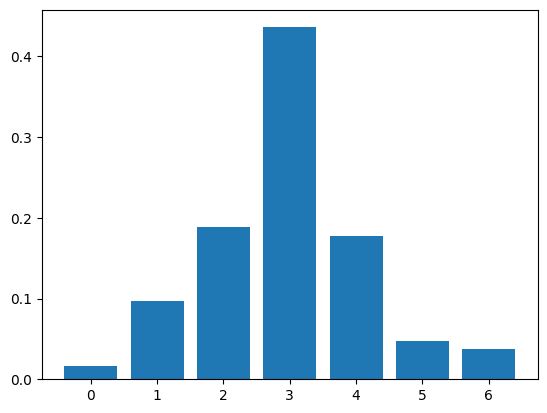

In [17]:
plt.bar(jnp.arange(7), policy_output.action_weights.mean(axis=0))
plt.show()

In [18]:
player_1_ai = True
player_2_ai = True

key = jax.random.PRNGKey(0)
env = env_reset(0)
print_board(env.board)
while True:
    if player_1_ai:
        action = run_mcts(key, env, 1000).action_weights.argmax().item()
    else:
        action = int(input()) - 1

    env, reward, done = env_step(env, action)
    print_board(env.board)
    if done: break

    if player_2_ai:
        action = run_mcts(key, env, 1000).action_weights.argmax().item()
    else:
        action = int(input()) - 1

    env, reward, done = env_step(env, action)
    print_board(env.board)
    if done: break

players = {
    1: "[green]X[/green]",
    -1: "[red]O[/red]",
}
print(f"Winner: {players[env.player.item()]}")

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   | X |   |   |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   | X |   | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   | X |   |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   | O |   |   |   |  
---|---|---|---|---|---|---
   |   | X |   |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   | O |   |   |   |  
---|---|---|---|---|---|---
   |   | X | X |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   | O |   |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   | O |   |   |  
---|---|---|---|---|---|---
   |   | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   | O |   |   |  
---|---|---|---|---|---|---
   |   | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   |   |  
---|---|---|---|---|---|---
 X | X | O | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   | O |   |   |  
---|---|---|---|---|---|---
   |   | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O |  
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   | O |   |   |  
---|---|---|---|---|---|---
   |   | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   | O |   |   |  
---|---|---|---|---|---|---
   |   |   | O |   |   |  
---|---|---|---|---|---|---
   |   | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   | O |   |   |  
---|---|---|---|---|---|---
   |   |   | O |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   |   | O |   |   |  
---|---|---|---|---|---|---
   |   | O | O |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   | X | O |   |   |  
---|---|---|---|---|---|---
   |   | O | O |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   |   |   |   |  
---|---|---|---|---|---|---
   |   | X | O |   |   |  
---|---|---|---|---|---|---
   | O | O | O |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   |   | X | O |   |   |  
---|---|---|---|---|---|---
   | O | O | O |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   |   | X | O |   |   |  
---|---|---|---|---|---|---
   | O | O | O |   |   |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   |   | X | O |   |   |  
---|---|---|---|---|---|---
   | O | O | O |   | X |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   |   |  
---|---|---|---|---|---|---
   | O | O | O |   | X |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
   | O | X | X |   | O |  
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   |   |  
---|---|---|---|---|---|---
   | O | O | O |   | X |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
   | O | X | X |   | O | X
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   |   |  
---|---|---|---|---|---|---
   | O | O | O |   | X |  
---|---|---|---|---|---|---
   | X | O | X |   | O |  
---|---|---|---|---|---|---
 O | O | X | X |   | O | X
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   |   |  
---|---|---|---|---|---|---
   | O | O | O |   | X |  
---|---|---|---|---|---|---
   | X | O | X |   | O | X
---|---|---|---|---|---|---
 O | O | X | X |   | O | X
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   |   |  
---|---|---|---|---|---|---
   | O | O | O |   | X | O
---|---|---|---|---|---|---
   | X | O | X |   | O | X
---|---|---|---|---|---|---
 O | O | X | X |   | O | X
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   |   | X
---|---|---|---|---|---|---
   | O | O | O |   | X | O
---|---|---|---|---|---|---
   | X | O | X |   | O | X
---|---|---|---|---|---|---
 O | O | X | X |   | O | X
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   | O | X
---|---|---|---|---|---|---
   | O | O | O |   | X | O
---|---|---|---|---|---|---
   | X | O | X |   | O | X
---|---|---|---|---|---|---
 O | O | X | X |   | O | X
---|---|---|---|---|---|---
 X | X | O | X |   | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   |   | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   | O | X
---|---|---|---|---|---|---
   | O | O | O |   | X | O
---|---|---|---|---|---|---
   | X | O | X |   | O | X
---|---|---|---|---|---|---
 O | O | X | X |   | O | X
---|---|---|---|---|---|---
 X | X | O | X | X | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   | O | X
---|---|---|---|---|---|---
   | O | O | O |   | X | O
---|---|---|---|---|---|---
   | X | O | X |   | O | X
---|---|---|---|---|---|---
 O | O | X | X |   | O | X
---|---|---|---|---|---|---
 X | X | O | X | X | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   | O | X
---|---|---|---|---|---|---
   | O | O | O |   | X | O
---|---|---|---|---|---|---
   | X | O | X |   | O | X
---|---|---|---|---|---|---
 O | O | X | X | X | O | X
---|---|---|---|---|---|---
 X | X | O | X | X | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   | O | X
---|---|---|---|---|---|---
   | O | O | O |   | X | O
---|---|---|---|---|---|---
   | X | O | X | O | O | X
---|---|---|---|---|---|---
 O | O | X | X | X | O | X
---|---|---|---|---|---|---
 X | X | O | X | X | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

|   | O | X |   |   |  
---|---|---|---|---|---|---
   | O | X | O |   | O | X
---|---|---|---|---|---|---
   | O | O | O | X | X | O
---|---|---|---|---|---|---
   | X | O | X | O | O | X
---|---|---|---|---|---|---
 O | O | X | X | X | O | X
---|---|---|---|---|---|---
 X | X | O | X | X | O | X
---|---|---|---|---|---|---
 1   2   3   4   5   6   7

Winner: X